# Building a Weather Station with TensorFlow Lite for Microcontrollers
**Final Project for [Kodołamacz Data Science PRO](https://datasciencepro.kodolamacz.pl/?_gl=1*f9bzqb*_ga*NzExNzQ1MTc5LjE2NzQ5NzkxMTM.*_ga_L4TZ9764GC*MTY5NTc0MTM1NS44My4wLjE2OTU3NDEzNTUuNjAuMC4w) Bootcamp, Author: Michał Dąbrowski, PhD**

## Motivation

I have been inspired by [Smart weather station challenge](https://challenge.aiforgood.itu.int/match/matchitem/71). Here is a short description of the problem in that competition:

> Developing Countries is the area of the globe where land-based, in situ monitoring of weather and climate is at its scarcest, but at the same time has arguably the most potential to benefit society. Rainfall and temperature can have high spatial variability due to the strong feedback that can exist between the land and atmosphere. Temperature can change rapidly in space due to land-cover heterogeneity and changing altitude over complex mountainous terrain. This means that a weather station tens of kilometers away may measure conditions that have little relevance to your location, making it hard to make informed local decisions. Attempts can be made to supplement weather information with satellite data, but these infer rainfall and near surface temperature at spatially averaged scales exceeding 10km and are subject to considerable uncertainties despite advances in sensor technology; moreover some data such as near surface winds or solar flux are not available at all. Local weather information can have a huge impact on communities and applications enabled by granular weather data include agriculture, change in prices of commodities and early warning systems.

<p align="center" width="100%">
 <img src="./graphics/weather_map2.png" width="400"/>
</p>

The goal of this challenge was to develop a fully functioning low-power, reliable, accurate, easy to install and maintain cost effective [weather station based on a single device](./TinyML_Challenge_2022_CSEM_report.pdf) able to detect all weather parameters including __TPH__ (temperature, pressure and humidity), wind and rain with no moving parts based on ultra-low power machine learning at the edge, that can be deployed locally in a farm, for example, to provide local conditions and assist farmers in deciding when to plant crops. __Thus I decided to build my own microcontroller-based station to predict weather conditions in Warsaw using [TinyML framework](https://www.oreilly.com/library/view/tinyml/9781492052036/).__

### TinyML with TensorFlow Lite for Microcontrollers (TFLu) with Arduino Nano 33 BLE Sense
TinyML is a new technology that allows Machine Learning (ML) models to run on low-power microcontrollers that do not require a network infrastructure. Generally, these devices have limited memory and computational capabilities, but they can _sense_ the physical environment through sensors and act based on the decisions taken by ML algorithms. It is firmly believed TinyML has a great role to play not only to reach the Sustainable Development Goals, but also to facilitate scientific research in areas such as environmental monitoring, physics of complex systems and energy management. One of the most popular and easy to develop model with is the [**Arduino Nano 33 BLE Sense**](https://docs.arduino.cc/hardware/nano-33-ble-sense) board with support from [**Tensor Flow Lite for Microcontrollers**](https://www.tensorflow.org/lite/microcontrollers) (TFLu) framework allowing running deep learning models on devices with a few kilobytes of memory, which we use to realize the current project. Written in C/C++, the library requires neither an operating system nor dynamic memory allocation. The **Arduino Nano 33 BLE Sens** currently has __TPH sensors__ which enable the temperature, humidity and atmospheric pressure measurements on-device in real time. Similar [weather stations](https://github.com/FlorinAndrei/WeatherStation) were realized in the past using different microcontrollers platforms and datasets e.g., [here](https://www.seeedstudio.com/blog/2021/02/23/build-a-tinyml-smart-weather-station-with-wio-terminal/) or [there](https://www.seeedstudio.com/blog/2021/02/23/build-a-tinyml-smart-weather-station-with-wio-terminal/) thus being helpful as as a source of inspiration and code snippets.

<p align="center" width="100%">
 <img src="https://courses.edx.org/assets/courseware/v1/c97238ff2db3e1872c67968473dc482f/asset-v1:HarvardX+TinyML3+1T2023+type@asset+block/pasted_image_0.png" width="600"/>
</p>

> __NOTE__: Excelent curated list of interesting resources on TinyML (articles, courses, books, and projects) is provided on [gitHub](https://github.com/gigwegbe/tinyml-papers-and-projects) profile.

## Project Dependencies

For details about the version of the Python packages installed when running the current notebook, see [requirements.txt](./requirements.txt).

In [4]:
# !pip install -r requirements.txt

### Python Libraries

In [2]:
import csv
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf

from numpy import mean
from numpy import std
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import activations
from tensorflow.keras import layers

sns.set()

### Constants

In [200]:
BATCH_SIZE = 64
MELTING_TEMPERATURE = 2
MIN_SNOW_CM = 0.5 # Above this value, we consider it as snow
NUM_EPOCHS = 20
OUTPUT_DATASET_FILE = "dataset.csv"
TFL_MODEL_FILE = "forecast_model.tflite"
TFL_MODEL_HEADER_FILE = "model.h"
TF_MODEL = "forecast"

## Importing weather data from _WorldWeatherOnline_

On the internet, there are various sources from which we can gather hourly weather data, but most of them are not free or have limited usage. I decided to use [**WorldWeatherOnline**](https://www.worldweatheronline.com/weather-api/) which has a free trial period for 30 days and provides simple [API](https://www.worldweatheronline.com/weather-api/api/docs/historical-weather-api.aspx) through HTTP requests to aquire the data (including historical data from July 1, 2008) for different locations worldwide. However, we can use an existing [Python wrapper](https://pypi.org/project/wwo-hist/) to export the data directly to __pandas__ `DataFrame` or save them into `CSV` file. Other solutions will require web scrapping (using `selenium` webdriver), gathering the data from [another database](https://www.weatherapi.com/) or external file.

> __NOTE:__ The original wrapper file needs to be modified as it does not work for `pandas` versions later than 1.3.5 (argument `closed` is no longer supported and needs to be removed from arguments list). Please find properly modified `retrieve_this_location()` function [here](./wwo_hist-0.0.7/wwo_hist/__init__.py) (`__init__.py` file) and replace the original `__init__.py` file from the Python packages directory corresponding to `wwo-hist` package.

In [167]:
# !pip install wwo-hist
from wwo_hist import retrieve_hist_data  # WorldWeatherOnline

In [168]:
# acquire data from 01-JUL-2008 to 31-AUG-2023) with an hourly frequency from Warsaw

api_key = '<YOUR_PERSONAL_API_KEY>'  # you need to register to obtain a personal API key (FREE 500 queries/day)
location_list = ['warsaw']
start_date = '01-JUL-2008'
end_date = '31-AUG-2023'
frequency=1  # weather conditions every 1 hour (costs 1 query for a whole month period per single location)

# retrieve_hist_data returns a list of dataframe(s)
df_weather = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = False,
                                store_df = True)



Retrieving weather data for canazei


Currently retrieving data for canazei: from 2008-07-01 to 2008-07-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:02.269972
Currently retrieving data for canazei: from 2008-07-01 to 2008-08-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:04.749223
Currently retrieving data for canazei: from 2008-08-01 to 2008-09-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:07.632444
Currently retrieving data for canazei: from 2008-09-01 to 2008-10-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:10.501441
Currently retrieving data for canazei: from 2008-10-01 to 2008-11-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:13.310356
Currently retrieving data for canazei: from 2008-11-01 to 2008-12-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:15.778659
Currently retrieving data for canazei: from 2008-12-01 to 2009-01-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:17.737126
Currently retrieving data for canazei: from 2009-01-01 to 2009-02-28


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:19.947903
Currently retrieving data for canazei: from 2009-02-01 to 2009-03-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:22.458777
Currently retrieving data for canazei: from 2009-03-01 to 2009-04-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:24.578432
Currently retrieving data for canazei: from 2009-04-01 to 2009-05-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:26.392804
Currently retrieving data for canazei: from 2009-05-01 to 2009-06-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:27.786700
Currently retrieving data for canazei: from 2009-06-01 to 2009-07-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:29.633051
Currently retrieving data for canazei: from 2009-07-01 to 2009-08-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:31.708760
Currently retrieving data for canazei: from 2009-08-01 to 2009-09-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:33.537756
Currently retrieving data for canazei: from 2009-09-01 to 2009-10-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:34.877299
Currently retrieving data for canazei: from 2009-10-01 to 2009-11-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:36.195806
Currently retrieving data for canazei: from 2009-11-01 to 2009-12-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:37.706072
Currently retrieving data for canazei: from 2009-12-01 to 2010-01-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:39.031799
Currently retrieving data for canazei: from 2010-01-01 to 2010-02-28


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:40.396851
Currently retrieving data for canazei: from 2010-02-01 to 2010-03-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:41.795552
Currently retrieving data for canazei: from 2010-03-01 to 2010-04-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:43.033843
Currently retrieving data for canazei: from 2010-04-01 to 2010-05-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:44.444965
Currently retrieving data for canazei: from 2010-05-01 to 2010-06-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:45.967794
Currently retrieving data for canazei: from 2010-06-01 to 2010-07-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:48.015891
Currently retrieving data for canazei: from 2010-07-01 to 2010-08-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:49.587984
Currently retrieving data for canazei: from 2010-08-01 to 2010-09-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:51.462982
Currently retrieving data for canazei: from 2010-09-01 to 2010-10-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:52.677212
Currently retrieving data for canazei: from 2010-10-01 to 2010-11-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:53.932622
Currently retrieving data for canazei: from 2010-11-01 to 2010-12-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:55.500695
Currently retrieving data for canazei: from 2010-12-01 to 2011-01-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:56.794956
Currently retrieving data for canazei: from 2011-01-01 to 2011-02-28


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:58.435719
Currently retrieving data for canazei: from 2011-02-01 to 2011-03-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:00:59.908529
Currently retrieving data for canazei: from 2011-03-01 to 2011-04-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:01.231473
Currently retrieving data for canazei: from 2011-04-01 to 2011-05-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:02.672274
Currently retrieving data for canazei: from 2011-05-01 to 2011-06-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:04.015676
Currently retrieving data for canazei: from 2011-06-01 to 2011-07-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:05.646802
Currently retrieving data for canazei: from 2011-07-01 to 2011-08-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:07.276324
Currently retrieving data for canazei: from 2011-08-01 to 2011-09-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:09.121274
Currently retrieving data for canazei: from 2011-09-01 to 2011-10-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:10.526061
Currently retrieving data for canazei: from 2011-10-01 to 2011-11-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:11.667907
Currently retrieving data for canazei: from 2011-11-01 to 2011-12-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:12.959827
Currently retrieving data for canazei: from 2011-12-01 to 2012-01-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:14.371806
Currently retrieving data for canazei: from 2012-01-01 to 2012-02-29


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:15.931713
Currently retrieving data for canazei: from 2012-02-01 to 2012-03-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:17.377208
Currently retrieving data for canazei: from 2012-03-01 to 2012-04-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:18.929179
Currently retrieving data for canazei: from 2012-04-01 to 2012-05-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:20.392955
Currently retrieving data for canazei: from 2012-05-01 to 2012-06-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:21.831546
Currently retrieving data for canazei: from 2012-06-01 to 2012-07-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:23.117151
Currently retrieving data for canazei: from 2012-07-01 to 2012-08-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:24.868748
Currently retrieving data for canazei: from 2012-08-01 to 2012-09-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:26.319355
Currently retrieving data for canazei: from 2012-09-01 to 2012-10-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:27.677659
Currently retrieving data for canazei: from 2012-10-01 to 2012-11-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:28.970254
Currently retrieving data for canazei: from 2012-11-01 to 2012-12-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:30.291392
Currently retrieving data for canazei: from 2012-12-01 to 2013-01-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:31.760260
Currently retrieving data for canazei: from 2013-01-01 to 2013-02-28


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:33.041613
Currently retrieving data for canazei: from 2013-02-01 to 2013-03-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:34.524653
Currently retrieving data for canazei: from 2013-03-01 to 2013-04-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:35.772521
Currently retrieving data for canazei: from 2013-04-01 to 2013-05-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:37.192580
Currently retrieving data for canazei: from 2013-05-01 to 2013-06-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:38.652275
Currently retrieving data for canazei: from 2013-06-01 to 2013-07-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:40.200763
Currently retrieving data for canazei: from 2013-07-01 to 2013-08-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:41.475832
Currently retrieving data for canazei: from 2013-08-01 to 2013-09-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:42.841095
Currently retrieving data for canazei: from 2013-09-01 to 2013-10-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:44.327958
Currently retrieving data for canazei: from 2013-10-01 to 2013-11-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:45.646687
Currently retrieving data for canazei: from 2013-11-01 to 2013-12-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:47.043102
Currently retrieving data for canazei: from 2013-12-01 to 2014-01-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:48.368100
Currently retrieving data for canazei: from 2014-01-01 to 2014-02-28


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:49.925184
Currently retrieving data for canazei: from 2014-02-01 to 2014-03-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:51.433843
Currently retrieving data for canazei: from 2014-03-01 to 2014-04-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:52.734997
Currently retrieving data for canazei: from 2014-04-01 to 2014-05-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:54.456774
Currently retrieving data for canazei: from 2014-05-01 to 2014-06-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:55.902318
Currently retrieving data for canazei: from 2014-06-01 to 2014-07-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:57.376568
Currently retrieving data for canazei: from 2014-07-01 to 2014-08-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:01:59.014942
Currently retrieving data for canazei: from 2014-08-01 to 2014-09-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:00.288524
Currently retrieving data for canazei: from 2014-09-01 to 2014-10-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:01.503068
Currently retrieving data for canazei: from 2014-10-01 to 2014-11-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:02.710722
Currently retrieving data for canazei: from 2014-11-01 to 2014-12-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:03.986957
Currently retrieving data for canazei: from 2014-12-01 to 2015-01-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:05.265336
Currently retrieving data for canazei: from 2015-01-01 to 2015-02-28


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:06.464058
Currently retrieving data for canazei: from 2015-02-01 to 2015-03-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:07.770307
Currently retrieving data for canazei: from 2015-03-01 to 2015-04-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:09.468113
Currently retrieving data for canazei: from 2015-04-01 to 2015-05-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:10.829773
Currently retrieving data for canazei: from 2015-05-01 to 2015-06-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:12.107095
Currently retrieving data for canazei: from 2015-06-01 to 2015-07-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:13.318580
Currently retrieving data for canazei: from 2015-07-01 to 2015-08-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:14.653101
Currently retrieving data for canazei: from 2015-08-01 to 2015-09-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:16.062525
Currently retrieving data for canazei: from 2015-09-01 to 2015-10-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:17.581802
Currently retrieving data for canazei: from 2015-10-01 to 2015-11-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:18.805219
Currently retrieving data for canazei: from 2015-11-01 to 2015-12-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:20.091990
Currently retrieving data for canazei: from 2015-12-01 to 2016-01-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:21.589809
Currently retrieving data for canazei: from 2016-01-01 to 2016-02-29


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:22.980506
Currently retrieving data for canazei: from 2016-02-01 to 2016-03-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:24.126443
Currently retrieving data for canazei: from 2016-03-01 to 2016-04-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:25.572558
Currently retrieving data for canazei: from 2016-04-01 to 2016-05-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:26.988731
Currently retrieving data for canazei: from 2016-05-01 to 2016-06-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:28.178709
Currently retrieving data for canazei: from 2016-06-01 to 2016-07-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:29.448631
Currently retrieving data for canazei: from 2016-07-01 to 2016-08-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:30.731455
Currently retrieving data for canazei: from 2016-08-01 to 2016-09-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:31.911757
Currently retrieving data for canazei: from 2016-09-01 to 2016-10-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:33.347993
Currently retrieving data for canazei: from 2016-10-01 to 2016-11-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:34.600892
Currently retrieving data for canazei: from 2016-11-01 to 2016-12-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:35.798720
Currently retrieving data for canazei: from 2016-12-01 to 2017-01-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:37.155214
Currently retrieving data for canazei: from 2017-01-01 to 2017-02-28


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:38.539780
Currently retrieving data for canazei: from 2017-02-01 to 2017-03-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:39.916050
Currently retrieving data for canazei: from 2017-03-01 to 2017-04-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:41.165198
Currently retrieving data for canazei: from 2017-04-01 to 2017-05-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:43.089706
Currently retrieving data for canazei: from 2017-05-01 to 2017-06-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:44.454638
Currently retrieving data for canazei: from 2017-06-01 to 2017-07-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:45.634357
Currently retrieving data for canazei: from 2017-07-01 to 2017-08-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:46.801554
Currently retrieving data for canazei: from 2017-08-01 to 2017-09-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:48.084928
Currently retrieving data for canazei: from 2017-09-01 to 2017-10-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:49.308510
Currently retrieving data for canazei: from 2017-10-01 to 2017-11-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:50.537294
Currently retrieving data for canazei: from 2017-11-01 to 2017-12-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:51.839783
Currently retrieving data for canazei: from 2017-12-01 to 2018-01-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:53.687167
Currently retrieving data for canazei: from 2018-01-01 to 2018-02-28


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:55.196845
Currently retrieving data for canazei: from 2018-02-01 to 2018-03-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:56.617423
Currently retrieving data for canazei: from 2018-03-01 to 2018-04-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:57.873880
Currently retrieving data for canazei: from 2018-04-01 to 2018-05-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:02:59.205448
Currently retrieving data for canazei: from 2018-05-01 to 2018-06-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:00.439220
Currently retrieving data for canazei: from 2018-06-01 to 2018-07-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:01.591454
Currently retrieving data for canazei: from 2018-07-01 to 2018-08-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:02.772292
Currently retrieving data for canazei: from 2018-08-01 to 2018-09-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:04.097187
Currently retrieving data for canazei: from 2018-09-01 to 2018-10-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:05.371563
Currently retrieving data for canazei: from 2018-10-01 to 2018-11-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:06.592516
Currently retrieving data for canazei: from 2018-11-01 to 2018-12-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:07.858452
Currently retrieving data for canazei: from 2018-12-01 to 2019-01-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:09.224807
Currently retrieving data for canazei: from 2019-01-01 to 2019-02-28


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:10.503328
Currently retrieving data for canazei: from 2019-02-01 to 2019-03-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:11.832763
Currently retrieving data for canazei: from 2019-03-01 to 2019-04-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:13.120722
Currently retrieving data for canazei: from 2019-04-01 to 2019-05-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:14.414827
Currently retrieving data for canazei: from 2019-05-01 to 2019-06-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:15.642600
Currently retrieving data for canazei: from 2019-06-01 to 2019-07-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:16.916705
Currently retrieving data for canazei: from 2019-07-01 to 2019-08-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:18.102412
Currently retrieving data for canazei: from 2019-08-01 to 2019-09-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:19.346163
Currently retrieving data for canazei: from 2019-09-01 to 2019-10-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:20.552918
Currently retrieving data for canazei: from 2019-10-01 to 2019-11-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:21.792441
Currently retrieving data for canazei: from 2019-11-01 to 2019-12-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:23.079018
Currently retrieving data for canazei: from 2019-12-01 to 2020-01-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:24.660451
Currently retrieving data for canazei: from 2020-01-01 to 2020-02-29


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:26.268373
Currently retrieving data for canazei: from 2020-02-01 to 2020-03-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:27.626775
Currently retrieving data for canazei: from 2020-03-01 to 2020-04-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:29.035846
Currently retrieving data for canazei: from 2020-04-01 to 2020-05-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:30.343239
Currently retrieving data for canazei: from 2020-05-01 to 2020-06-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:31.674522
Currently retrieving data for canazei: from 2020-06-01 to 2020-07-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:32.909557
Currently retrieving data for canazei: from 2020-07-01 to 2020-08-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:34.202901
Currently retrieving data for canazei: from 2020-08-01 to 2020-09-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:35.458547
Currently retrieving data for canazei: from 2020-09-01 to 2020-10-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:36.766898
Currently retrieving data for canazei: from 2020-10-01 to 2020-11-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:38.006053
Currently retrieving data for canazei: from 2020-11-01 to 2020-12-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:39.498061
Currently retrieving data for canazei: from 2020-12-01 to 2021-01-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:40.878880
Currently retrieving data for canazei: from 2021-01-01 to 2021-02-28


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:42.300041
Currently retrieving data for canazei: from 2021-02-01 to 2021-03-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:43.481399
Currently retrieving data for canazei: from 2021-03-01 to 2021-04-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:44.743016
Currently retrieving data for canazei: from 2021-04-01 to 2021-05-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:46.165942
Currently retrieving data for canazei: from 2021-05-01 to 2021-06-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:47.484028
Currently retrieving data for canazei: from 2021-06-01 to 2021-07-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:48.818853
Currently retrieving data for canazei: from 2021-07-01 to 2021-08-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:50.113414
Currently retrieving data for canazei: from 2021-08-01 to 2021-09-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:51.454496
Currently retrieving data for canazei: from 2021-09-01 to 2021-10-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:52.696199
Currently retrieving data for canazei: from 2021-10-01 to 2021-11-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:53.997811
Currently retrieving data for canazei: from 2021-11-01 to 2021-12-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:55.545473
Currently retrieving data for canazei: from 2021-12-01 to 2022-01-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:56.790109
Currently retrieving data for canazei: from 2022-01-01 to 2022-02-28


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:58.032649
Currently retrieving data for canazei: from 2022-02-01 to 2022-03-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:03:59.282315
Currently retrieving data for canazei: from 2022-03-01 to 2022-04-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:04:00.600120
Currently retrieving data for canazei: from 2022-04-01 to 2022-05-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:04:02.099412
Currently retrieving data for canazei: from 2022-05-01 to 2022-06-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:04:03.345383
Currently retrieving data for canazei: from 2022-06-01 to 2022-07-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:04:04.524389
Currently retrieving data for canazei: from 2022-07-01 to 2022-08-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:04:05.790137
Currently retrieving data for canazei: from 2022-08-01 to 2022-09-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:04:07.217071
Currently retrieving data for canazei: from 2022-09-01 to 2022-10-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:04:08.472875
Currently retrieving data for canazei: from 2022-10-01 to 2022-11-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:04:09.775166
Currently retrieving data for canazei: from 2022-11-01 to 2022-12-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:04:11.253455
Currently retrieving data for canazei: from 2022-12-01 to 2023-01-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:04:12.736667
Currently retrieving data for canazei: from 2023-01-01 to 2023-02-28


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:04:14.121502
Currently retrieving data for canazei: from 2023-02-01 to 2023-03-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:04:15.351552
Currently retrieving data for canazei: from 2023-03-01 to 2023-04-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:04:16.699466
Currently retrieving data for canazei: from 2023-04-01 to 2023-05-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:04:18.989979
Currently retrieving data for canazei: from 2023-05-01 to 2023-06-30


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:04:21.349144
Currently retrieving data for canazei: from 2023-06-01 to 2023-07-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:04:23.314857
Currently retrieving data for canazei: from 2023-07-01 to 2023-08-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:04:25.324618
Currently retrieving data for canazei: from 2023-08-01 to 2023-08-31


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

Time elapsed (hh:mm:ss.ms) 0:04:26.999599


/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/wwo_hist/__init__.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffil

In [169]:
# export to CSV file
df_weather[0].to_csv('weather_warsaw.csv', index=False)

The `weather` dataset includes several weather conditions for each requested date and time. For example, we can ind the pressure in milibars, cloud coverage in percentage, visibility in kilometers, and of course other physical quantities. The effectiveness of ML algorithms depends heavily on the data used for training (hence _ML model is only as good as the dataset_). Considering the weather prediciton context, we know from physics that temperature and humidity affect snow formation. Thus, we gather historical hourly temperature, humidity and snowfall data to build a __TinyML__ snow forecasting application based on data from the past three hours.

In [201]:
df_weather = pd.read_csv('weather_warsaw.csv')
df_weather.head()

date_time  maxtempC  mintempC  totalSnow_cm  sunHour  uvIndex  \
0  2008-07-01 00:00:00        24        13           0.0     16.8        5   
1  2008-07-01 01:00:00        24        13           0.0     16.8        5   
2  2008-07-01 02:00:00        24        13           0.0     16.8        5   
3  2008-07-01 03:00:00        24        13           0.0     16.8        5   
4  2008-07-01 04:00:00        24        13           0.0     16.8        5   

   moon_illumination  moonrise   moonset   sunrise  ... WindGustKmph  \
0                  4  01:47 AM  08:04 PM  04:19 AM  ...           15   
1                  4  01:47 AM  08:04 PM  04:19 AM  ...           16   
2                  4  01:47 AM  08:04 PM  04:19 AM  ...           16   
3                  4  01:47 AM  08:04 PM  04:19 AM  ...           12   
4                  4  01:47 AM  08:04 PM  04:19 AM  ...           12   

   cloudcover  humidity  precipMM  pressure  tempC  visibility  winddirDegree  \
0           5        86       0.0      1020     15          10            353   
1           5        86       0.0      1020     14          10            335   
2           6        86       0.0      1020     13          10            317   
3           6        86       0.0      1021     13          10            299   
4           6        77       0.0      1021     14          10            301   

   windspeedKmph  location  
0              5    warsaw  
1              5    warsaw  
2              6    warsaw  
3              6    warsaw  
4              7    warsaw  

[5 rows x 25 columns]

The physical quantities we are interested in:
- `tempC`: the temperature in degrees Celsius
- `humidity`: the relative air humidity in percentage
- `totalSnow_cm`: total snowfall in centimeters

In [202]:
# extract temperature, humidity and precipitation
t_list = df_weather.tempC.astype(float).to_list()
h_list = df_weather.humidity.astype(float).to_list()
s_list = df_weather.totalSnow_cm.astype(float).to_list()

## Exploratory Data Analysis

/tmp/ipykernel_1080/3810312404.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sc)


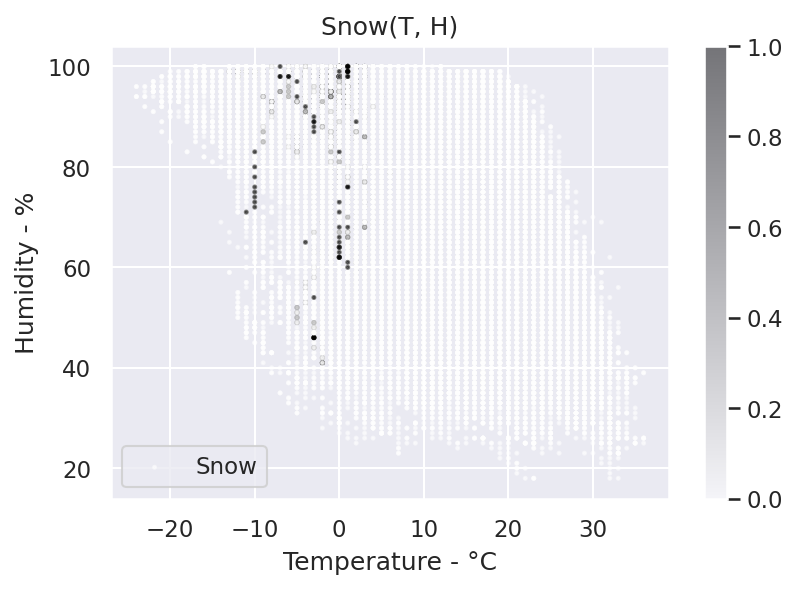

In [203]:
# explore the extracted physical quantities in a 2D scatter chart

def binarize(snow, threshold):
    if snow > threshold:
        return 1
    else:
        return 0

s_bin_list = [binarize(snow, MIN_SNOW_CM) for snow in s_list]

cm = plt.cm.get_cmap('gray_r')
plt.figure(figsize=(6, 4), dpi=150)
sc = plt.scatter(t_list, h_list, c=s_bin_list, cmap=cm, s=2, label="Snow", alpha=0.5)
plt.colorbar(sc)
plt.legend()
plt.grid(True)
plt.title("Snow(T, H)")
plt.xlabel("Temperature - °C")
plt.ylabel("Humidity - %")
plt.show()

As we can see from the distribution of the black dots, there are cases where the snow formation is reported for temperatures well above 0 Celsius degree. To simplify the analysis, we set the maximum temparature for snow formation as `MELTING_TEMP` and consider the snow formation only when the snowfall is above `MIN_SNOW_CM`. Since we are only forecasting snow, only two classes are needed (__classification problem__).

In [204]:
def gen_label(snow, temperature):
    '''Generate the output labels (Yes and No)'''
    if snow > MIN_SNOW_CM and temperature < MELTING_TEMPERATURE:
        return "Yes"
    else:
        return "No"

snow_labels = [gen_label(snow, temp) for snow, temp in zip(s_list, t_list)]

In [205]:
# build the dataset

csv_header = ["Temp0", "Temp1", "Temp2", "Humi0", "Humi1", "Humi2", "Snow"]

df_dataset = pd.DataFrame(list(zip(t_list[:-2], t_list[1:-1], t_list[2:], h_list[:-2], h_list[1:-1], h_list[2:], snow_labels[2:])), columns = csv_header)

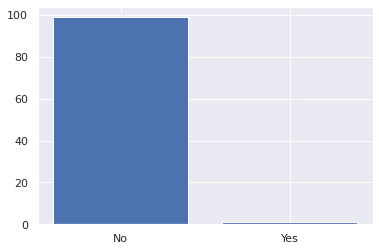

In [206]:
# balance the dataset by undersampling the majority class

df0 = df_dataset[df_dataset['Snow'] == "No"]
df1 = df_dataset[df_dataset['Snow'] == "Yes"]

num_nosnow_samples_old = round((len(df0.index) / (len(df_dataset.index))) * 100, 2)
num_snow_samples_old   = round((len(df1.index) / (len(df_dataset.index))) * 100, 2)

plt.bar(np.unique(df_dataset['Snow'].values), [num_nosnow_samples_old, num_snow_samples_old]);

The original dataset is unbalanced because in the selected location (Warsaw, Poland), it typically snows just during the winter season. Since the minority class has many samples (around 2000), we can randomly undersample the majority class so the two categories have the same number of observations. Another approach might include oversampling the minority class (e.g.,  generating them using _SMOTE_ technique).

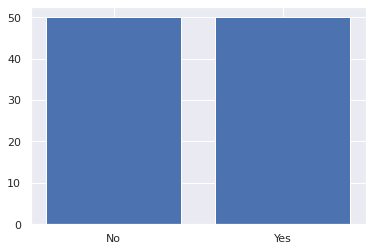

In [207]:
# Random subsampling of the majority class to guarantee 50% split
if len(df1.index) < len(df0.index):
    df0_sub = df0.sample(len(df1.index))
    df_dataset = pd.concat([df0_sub, df1])
else:
    df1_sub = df1.sample(len(df0.index))
    df_dataset = pd.concat([df1_sub, df0])

df0 = df_dataset[df_dataset['Snow'] == "No"]
df1 = df_dataset[df_dataset['Snow'] == "Yes"]

num_nosnow_samples_new = round((len(df0.index) / (len(df_dataset.index))) * 100, 2)
num_snow_samples_new = round((len(df1.index) / (len(df_dataset.index))) * 100, 2)

plt.bar(np.unique(df_dataset['Snow'].values), [num_nosnow_samples_new, num_snow_samples_new]);

In [208]:
# Show number of samples
df_samples_results = pd.DataFrame.from_records(
                [["% No Snow", num_nosnow_samples_old, num_nosnow_samples_new],
                ["% Snow", num_snow_samples_old, num_snow_samples_new]],
            columns = ["Class", "Before - %", "After - %"], index="Class").round(2)

display(df_samples_results)

Before - %  After - %
Class                           
% No Snow       98.91       50.0
% Snow           1.09       50.0

## Feature Engineering

In [209]:
# Get all values
t_list = df_dataset['Temp0'].tolist()
h_list = df_dataset['Humi0'].tolist()
t_list = t_list + df_dataset['Temp2'].tail(2).tolist()
h_list = h_list + df_dataset['Humi2'].tail(2).tolist()

# Calculate mean and standard deviation
t_avg = mean(t_list)
h_avg = mean(h_list)
t_std = std(t_list)
h_std = std(h_list)
print("COPY ME!")
print("Temperature - [MEAN, STD]  ", round(t_avg, 5), round(t_std, 5))
print("Humidity - [MEAN, STD]     ", round(h_avg, 5), round(h_std, 5))

COPY ME!
Temperature - [MEAN, STD]   4.31994 8.69383
Humidity - [MEAN, STD]      83.48505 16.41409


> __IMPORTANT:__ Copy the printed mean and standard deviation values printed as they will be required when deploying the __TinyML__ application.

Our input features exist in different numerical ranges. For example, humidity is always between 0 and 100, while the temperature on the Celsius scale can be negative and has a smaller positive numerical range than humidity. The following charts compare the raw and scaled input featue distributions. This is a typical scenario when dealing with various physical quantities and could impact the effectiveness of the model training. As you can observe, Z-score provides roughly the same value range (x-axis) for both temperature and humidity features.

In [210]:
# scale the input features with Z-score independently

def scaling(val, avg, std):
    '''Z-score scaling'''
    return (val - avg) / (std)

df_dataset['Temp0'] = df_dataset['Temp0'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Temp1'] = df_dataset['Temp1'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Temp2'] = df_dataset['Temp2'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Humi0'] = df_dataset['Humi0'].apply(lambda x: scaling(x, h_avg, h_std))
df_dataset['Humi1'] = df_dataset['Humi1'].apply(lambda x: scaling(x, h_avg, h_std))
df_dataset['Humi2'] = df_dataset['Humi2'].apply(lambda x: scaling(x, h_avg, h_std))

/home/mdabrowski-phd/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

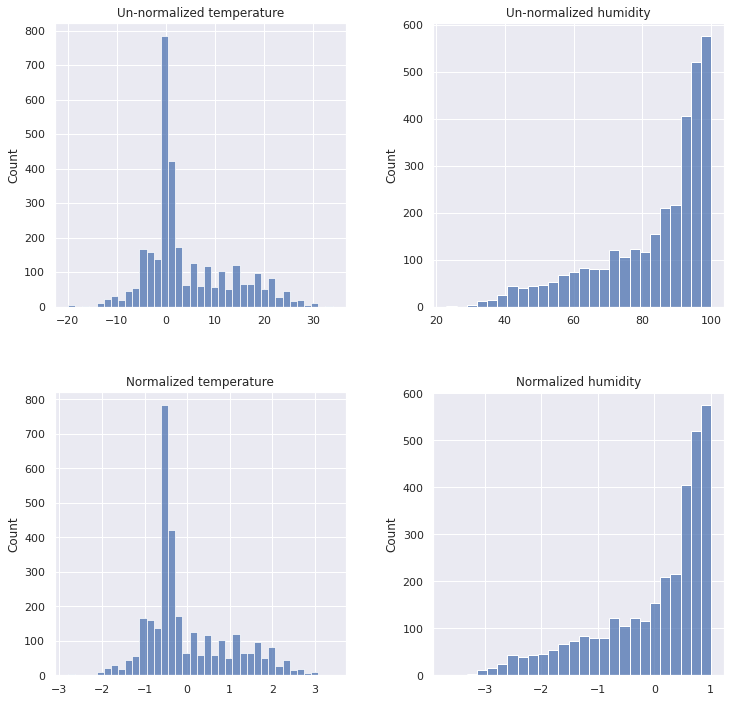

In [211]:
# visualize raw/scaled input features distributions

t_norm_list = df_dataset['Temp0'].tolist()
h_norm_list = df_dataset['Humi0'].tolist()
t_norm_list = t_norm_list + df_dataset['Temp2'].tail(2).tolist()
h_norm_list = h_norm_list + df_dataset['Humi2'].tail(2).tolist()

fig, ax=plt.subplots(2, 2, figsize=(12, 12))
plt.subplots_adjust(wspace = 0.3, hspace=0.3)

sns.histplot(t_list, ax=ax[0, 0])
ax[0, 0].set_title("Un-normalized temperature")
sns.histplot(h_list, ax=ax[0, 1])
ax[0, 1].set_title("Un-normalized humidity")

sns.histplot(t_norm_list, ax=ax[1, 0])
ax[1, 0].set_title("Normalized temperature")
sns.histplot(h_norm_list, ax=ax[1, 1])
ax[1, 1].set_title("Normalized humidity")

plt.show()

In [212]:
# export final dataset to CSV file
df_dataset.to_csv(f'./outputs/{OUTPUT_DATASET_FILE}', index=False)

## Deep Learning (DL) Model

When working with TinyML framework, we are limited __(?!)__ to the models offered by `TensorFlow` library which means we are restricted to different types of neural networks excluding other machine learning models (logistic regression, SVC, decission trees, random forests, etc.) offered by `sklearn`. First, the model is trained on PC (or in the cloud), then converted to __TFLu__ format and deployed on microcontroller as a part of `C/C++` application

In [213]:
# extract the input features and output labels from the df_dataset Pandas DataFrame

X = df_dataset.drop('Snow', axis=1)
y = df_dataset['Snow']

In [214]:
# encode the labels to numerical values

labelencoder = LabelEncoder()
labelencoder.fit(y)
y_encoded = labelencoder.transform(y)

/home/mdabrowski-phd/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/mdabrowski-phd/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

From the original dataset, we assign 85% records to the training set, 7.5% to the validation set, and last 7.5% to the test dataset. With this split, the validation and test datasets contain roughly 250 samples each, enough to see if the model works properly.

In [215]:
# split the dataset into train, validation, and test datasets

# Split 1 (85% vs 15%)
X_train, X_validate_test, y_train, y_validate_test = train_test_split(X, y_encoded, test_size=0.15, random_state = 1)
# Split 2 (50% vs 50%)
X_test, X_validate, y_test, y_validate = train_test_split(X_validate_test, y_validate_test, test_size=0.50, random_state = 3)

One of the most critical aspects to consider when deploying DL networks for __TinyML__ is the model size, generally defined as the memory required for storing the weights (as microcontrollers have very limited physical memory). The created DL model is a __binary classifier__ with an input layer providing the six input features to the network (the temperature and humidity for each of the last three hours) and one output node returning the probability of snowing weather. The structure of the model (consisting all hidden layers) is illustrated in the diagram:

<br>
<p align="center" width="100%">
 <img src="./graphics/NN_scheme1.png" width="600"/>
</p>

<br>

In [216]:
# create the model with Keras API

model = tf.keras.Sequential()
model.add(layers.Dense(12, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 12)                84        
                                                                 
 dropout_3 (Dropout)         (None, 12)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 13        
                                                                 
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


> __NOTE:__ In __TinyML__ it is important to keep an eye on the number of weights because it strongly affects microcontroller memory utilization.

In [217]:
# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [218]:
# train the model
history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_validate, y_validate))

Epoch 1/20
43/43 [==============================] - 1s 6ms/step - loss: 0.6346 - accuracy: 0.6713 - val_loss: 0.5599 - val_accuracy: 0.7925
Epoch 2/20
43/43 [==============================] - 0s 3ms/step - loss: 0.5167 - accuracy: 0.7953 - val_loss: 0.4917 - val_accuracy: 0.8257
Epoch 3/20
43/43 [==============================] - 0s 3ms/step - loss: 0.4556 - accuracy: 0.8269 - val_loss: 0.4503 - val_accuracy: 0.8174
Epoch 4/20
43/43 [==============================] - 0s 3ms/step - loss: 0.4221 - accuracy: 0.8368 - val_loss: 0.4244 - val_accuracy: 0.8133
Epoch 5/20
43/43 [==============================] - 0s 3ms/step - loss: 0.3945 - accuracy: 0.8434 - val_loss: 0.4068 - val_accuracy: 0.8133
Epoch 6/20
43/43 [==============================] - 0s 4ms/step - loss: 0.3883 - accuracy: 0.8415 - val_loss: 0.3927 - val_accuracy: 0.8257
Epoch 7/20
43/43 [==============================] - 0s 3ms/step - loss: 0.3640 - accuracy: 0.8544 - val_loss: 0.3819 - val_accuracy: 0.8299
Epoch 8/20
43/43 [==

In [219]:
# save the entire TensorFlow model as a SavedModel (ProtoBuffer, TF checkpoint and training parameters)
model.save(f'outputs/{TF_MODEL}')

INFO:tensorflow:Assets written to: outputs/forecast/assets


INFO:tensorflow:Assets written to: outputs/forecast/assets


Exporting the trained network as `SavedModel` saves the training graph (network architecture, weights, hiperparameters and checkpoints) thus such **TensorFlow** model is perfect for sharing or resuming a training session but not suitable for microcontroller deployment due to computational and memory constraints. Later on we will transform **TensorFlow** model into [**TensorFlow Lite (TFLite)**](https://www.tensorflow.org/lite/guide) model, and finally convert it to C-byte array.

## Evaluation and Performance

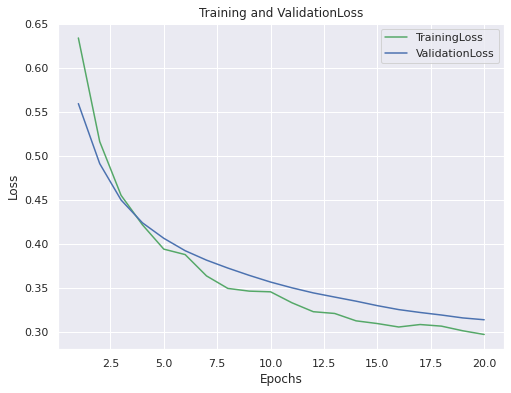

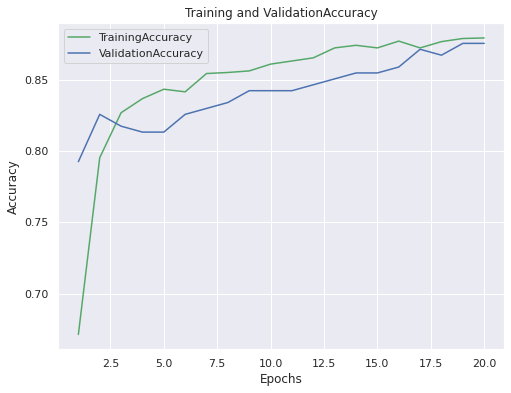

In [220]:
# analyze the accuracy and loss after each training epoch

loss_train = history.history['loss']
loss_val   = history.history['val_loss']
acc_train  = history.history['accuracy']
acc_val    = history.history['val_accuracy']
epochs     = range(1, NUM_EPOCHS + 1)

def plot_train_val_history(X, y_train, y_val, type_txt):
    plt.figure(figsize = (8, 6))
    plt.plot(X, y_train, 'g', label='Training'+type_txt)
    plt.plot(X, y_val, 'b', label='Validation'+type_txt)
    plt.title('Training and Validation'+type_txt)
    plt.xlabel('Epochs')
    plt.ylabel(type_txt)
    plt.legend()
    plt.show()

plot_train_val_history(epochs, loss_train, loss_val, "Loss")
plot_train_val_history(epochs, acc_train, acc_val, "Accuracy")

From the plots we see the accuracy and loss of our model in each training epoch thus can see the trend of model performance. The validation accuracy and loss obtain _a plateau_ after c.a. 10 epochs and there is no evidence of overfitting or underfitting (exceptional smaller loss for validation rather than training set can be explained by the fact the validation loss is calculated at the end of each training epoch). Thus, we should consider terminating the training earlier to prevent overfitting for other datasets (using e.g., `EarlyStopping()` method). However, accuracy and loss are not enough to judge the model performance.

8/8 [==============================] - 0s 2ms/step


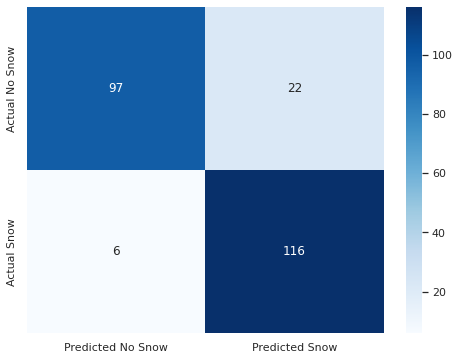

In [221]:
# visualize the confusion matrix

y_test_pred = model.predict(X_test)

y_test_pred = (y_test_pred > 0.5).astype("int32")

cm = sklearn.metrics.confusion_matrix(y_test, y_test_pred)

index_names  = ["Actual No Snow", "Actual Snow"]
column_names = ["Predicted No Snow", "Predicted Snow"]

df_cm = pd.DataFrame(cm, index = index_names, columns = column_names)

plt.figure(figsize = (8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues");

From confussion matrix we see the samples are mainly distributed on the diagonal, and there are more false-positives than false-negatives. Therefore, alhtough the network is suitable for detecting snow, we should expect some false detections.

In [222]:
# calculate Recall, Precision, and F-score performance metrics

TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]

accuracy = (TP + TN) / (TP + TN + FN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f_score = (2 * recall * precision) / (recall + precision)

print("Accuracy:  ", round(accuracy, 3))
print("Recall:    ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F-score:   ", round(f_score, 3))

Accuracy:   0.884
Recall:     0.951
Precision:  0.841
F-score:    0.892


As we can see from the high **recall**, our model can forecast the snow with high confidence. However, because of lower **precision** we should expect some false alarms. Finally, **F-score** tells us **recall** and **precision** are well-balanced. Therefore, we have a good ML model suitable for microcontroller deployment.

## TensorFlow Lite Conversion

[**TFLite**](https://www.tensorflow.org/lite/guide) is a deep learning framework specifically for inference on edge devices (smartphones and embedded platforms) which provides a set of tools for converting the **TF** model into a lightweight representation and running the model efficiently on the target device, as presented in the following diagram:

<br>
<p align="center" width="100%">
 <img src="./graphics/TLFu_scheme1.png" width="600"/>
</p>

<br>


In [223]:
# import the TensorFlow SavedModel directory into TensorFlow Lite Converter
converter = tf.lite.TFLiteConverter.from_saved_model(f'outputs/{TF_MODEL}')

Memorory constraint is not the only challenge when deploying a model on microcontrollers. Although the trained model commonly employs arithmetic operations in floating-point precision, CPUs on microcontrollers normally do not support them. [**Quantization**](https://www.tensorflow.org/lite/performance/post_training_quantization) is the process of performing neural network computations in lower bit precision. The widely adopted technique for microcontrollers applies quantization post-training and converst 32-bit floating-point weights to 8-bit integer values. This technique brings four times model size reduction and a significant latency improvement but may induce __accuracy drop__.

In [224]:
# TFLite converter uses X_test for calibration

def representative_data_gen():
    '''Select a few hundred of samples randomly from the training dataset to calibrate the quantization'''
    for i_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
        i_value_f32 = tf.dtypes.cast(i_value, tf.float32)
    yield [i_value_f32]

In [225]:
# initialize TensorFlow Lite converter for the 8-bit quantization

converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

The previous step is commonly called _generating a representative dataset_, and is essential to reduce the risk of an accuracy drop in the quantization process. In fact, the converter uses this set of samples to find out the range of the input values and then estimates the quantization parameters.

In [226]:
# convert the model to TensorFlow Lite file format (FlatBuffers) and save it as .tflite

tflite_model_quant = converter.convert()
open(f'outputs/{TFL_MODEL_FILE}', "wb").write(tflite_model_quant)

2023-09-29 15:34:22.240771: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-09-29 15:34:22.240839: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-09-29 15:34:22.240983: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: outputs/forecast
2023-09-29 15:34:22.250309: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-09-29 15:34:22.250341: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: outputs/forecast
2023-09-29 15:34:22.254415: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-09-29 15:34:22.305033: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: outputs/forecast
2023-09-29 15:34:22.311796: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: success: OK. Took 70815 m

2104

In [227]:
# convert the TensorFlow Lite model to C-byte array with xxd
 
!apt-get update && apt-get -qq install xxd

!xxd -i outputs/{TFL_MODEL_FILE} > outputs/{TFL_MODEL_HEADER_FILE}  # model conversion and storage in 'model.h' C header file  
!cat outputs/{TFL_MODEL_HEADER_FILE}  # array of hexadecimal numbers interpreted by TFLu framework on microcontroller

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
unsigned char outputs_forecast_model_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x88, 0x00, 0x00, 0x00, 0xe0, 0x00, 0x00, 0x00, 0x60, 0x02, 0x00, 0x00,
  0x70, 0x02, 0x00, 0x00, 0xcc, 0x07, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x56, 0xfd, 0xff, 0xff,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x38, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,


The `xxd` command outputs a C header file containing __TFLite__ model as C-byte array since microcontrollers may not have (or very limited) [__MbedOS__](https://os.mbed.com/mbed-os/) and support for loading the data from original `*.tflite` file. Therefore, it allows us to integrate the model directly into the application in a memory-efficient way.

### Evaluating the accuracy of the TFLite quantized model

Post-training quantization may change the model accuracy because of the arithmetic operations at a lower precision. Therefore, it is crucial to check whether the accuracy of the generated `*.tflite` model is within an acceptable range before deploying it into the microcontroller.

In [228]:
def classify(i_value, o_value):
    input_data = i_value.reshape(1, -1)
    i_value_f32 = tf.dtypes.cast(input_data, tf.float32)
  
    # Quantize (float -> 8-bit) the input (check if input layer is 8-bit, first)
    i_value_f32 = i_value_f32 / i_scale + i_zero_point
    i_value_s8 = tf.cast(i_value_f32, dtype=tf.int8)

    tfl_inter.set_tensor(i_details["index"], i_value_s8)
    tfl_inter.invoke()
    o_pred = tfl_inter.get_tensor(o_details["index"])[0]

    return (o_pred - o_zero_point) * o_scale

In [229]:
# Initialize the TFLite interpreter
tfl_inter = tf.lite.Interpreter(model_content=tflite_model_quant)

# Allocate the tensors
tfl_inter.allocate_tensors()

# Get input/output layer information
i_details = tfl_inter.get_input_details()[0]
o_details = tfl_inter.get_output_details()[0]

i_quant = i_details["quantization_parameters"]
o_quant = o_details["quantization_parameters"]
i_scale      = i_quant['scales'][0]
i_zero_point = i_quant['zero_points'][0]
o_scale      = o_quant['scales'][0]
o_zero_point = o_quant['zero_points'][0]

num_correct_samples = 0
num_total_samples   = len(list(y_test))

for i_value, o_value in zip(X_test.values, y_test):
    o_pred_f32 = classify(i_value, o_value)
    if np.argmax(o_pred_f32) == o_value:
        num_correct_samples += 1

In [230]:
print("Accuracy:", num_correct_samples / num_total_samples)

Accuracy: 0.49377593360995853


## Deployment on Arduino Board

**Arduino Nano 33 BLE Sens** has built-in __TPH__ (temperature, pressure and humidity) sensors so we do not need external components for building a simple weather station. The Arduino board integrates ultra-compact and extremaly low-power [HTS221 sensor](https://www.st.com/en/mems-and-sensors/hts221.html) for relative humidity and temperature measurements.

<br>
<p align="center" width="100%">
 <img src="./graphics/sensor_params.png" width="600"/>
</p>

<br>

> __IMPORTANT__: Due to [self-heating](https://forum.arduino.cc/t/how-to-make-a-weather-station-and-fix-temperature-sensor-readings-on-the-sense/624985), when the **Arduino Nano 33 BLE Sens** board is powered by USB, the HTS221 sensor becomes unreliable and shows an offset in each reading that changes with the external temperature. Thus, powering the board with batteries is recommended.

Please find an additional Jupyter Notebook with [ArduinoSketches](./notebook_ArduinoSketches.ipynb) written in C language for __TFLu__ model deployment on **Arduino Nano 33 BLE Sens** board. __TFLu__ framework does not need setting up as it is included as a separate library in the Arduino IDE environment. For those interested, very good, official tutorial showing how to configure the Arduino IDE, install __TFLu__ library and run first programs on **Arduino Nano 33 BLE Sens** can be found [here](https://docs.arduino.cc/tutorials/nano-33-ble-sense/get-started-with-machine-learning). Inference with __TFLu__ typically consists of the following steps, implemented in the Arduino application via external libraries:
1. __Loading and parsing the TFLite model__: TFLu parses the weights and network architecture stored in the C-byte array generated before
2. __Transforming the input data__: the input data acquired from the sensors is converted to the quantized format expected by the TFLu model
3. __Executing the model__: TFLu executes the model using optimized deep neural network functions (like convolutions, matrix multiplications, etc.)

> __NOTE__: At the end of Arduino sketches code, there is a delay of <u>two seconds</u> but is should be <u>one hour</u> in the actual application! The pause of two seconds is used to avoid waiting too long in our experiments (we have decided to predict weather in an hourly manner). Also, in the `DEBUG_SNOW` mode there are implemented conditions where model predict snowing weather (to check if the logic of Arduino application works). Please remember that **mean** and **std** of temperature and humidity extracted from TF model <u>must be copied</u> into Arduino code as well.

After compiling and uploading the `classification.ino` sketch on the Arduino board (_sketch - including model - uses 25% of program storage space. Global variables use 19% of dynamic memory_), the serial port monitor in the _Arduino IDE_ will report ***Yes, it snows*** or ***No, it does not snow***, depending on whether snow is forecast at the moment. To check if the application can forecast snow, you can simply force the temperature to -10 Celsisus degree and humidity to 100%. The model should then return ***Yes, it snows*** message on the serial port monitor.

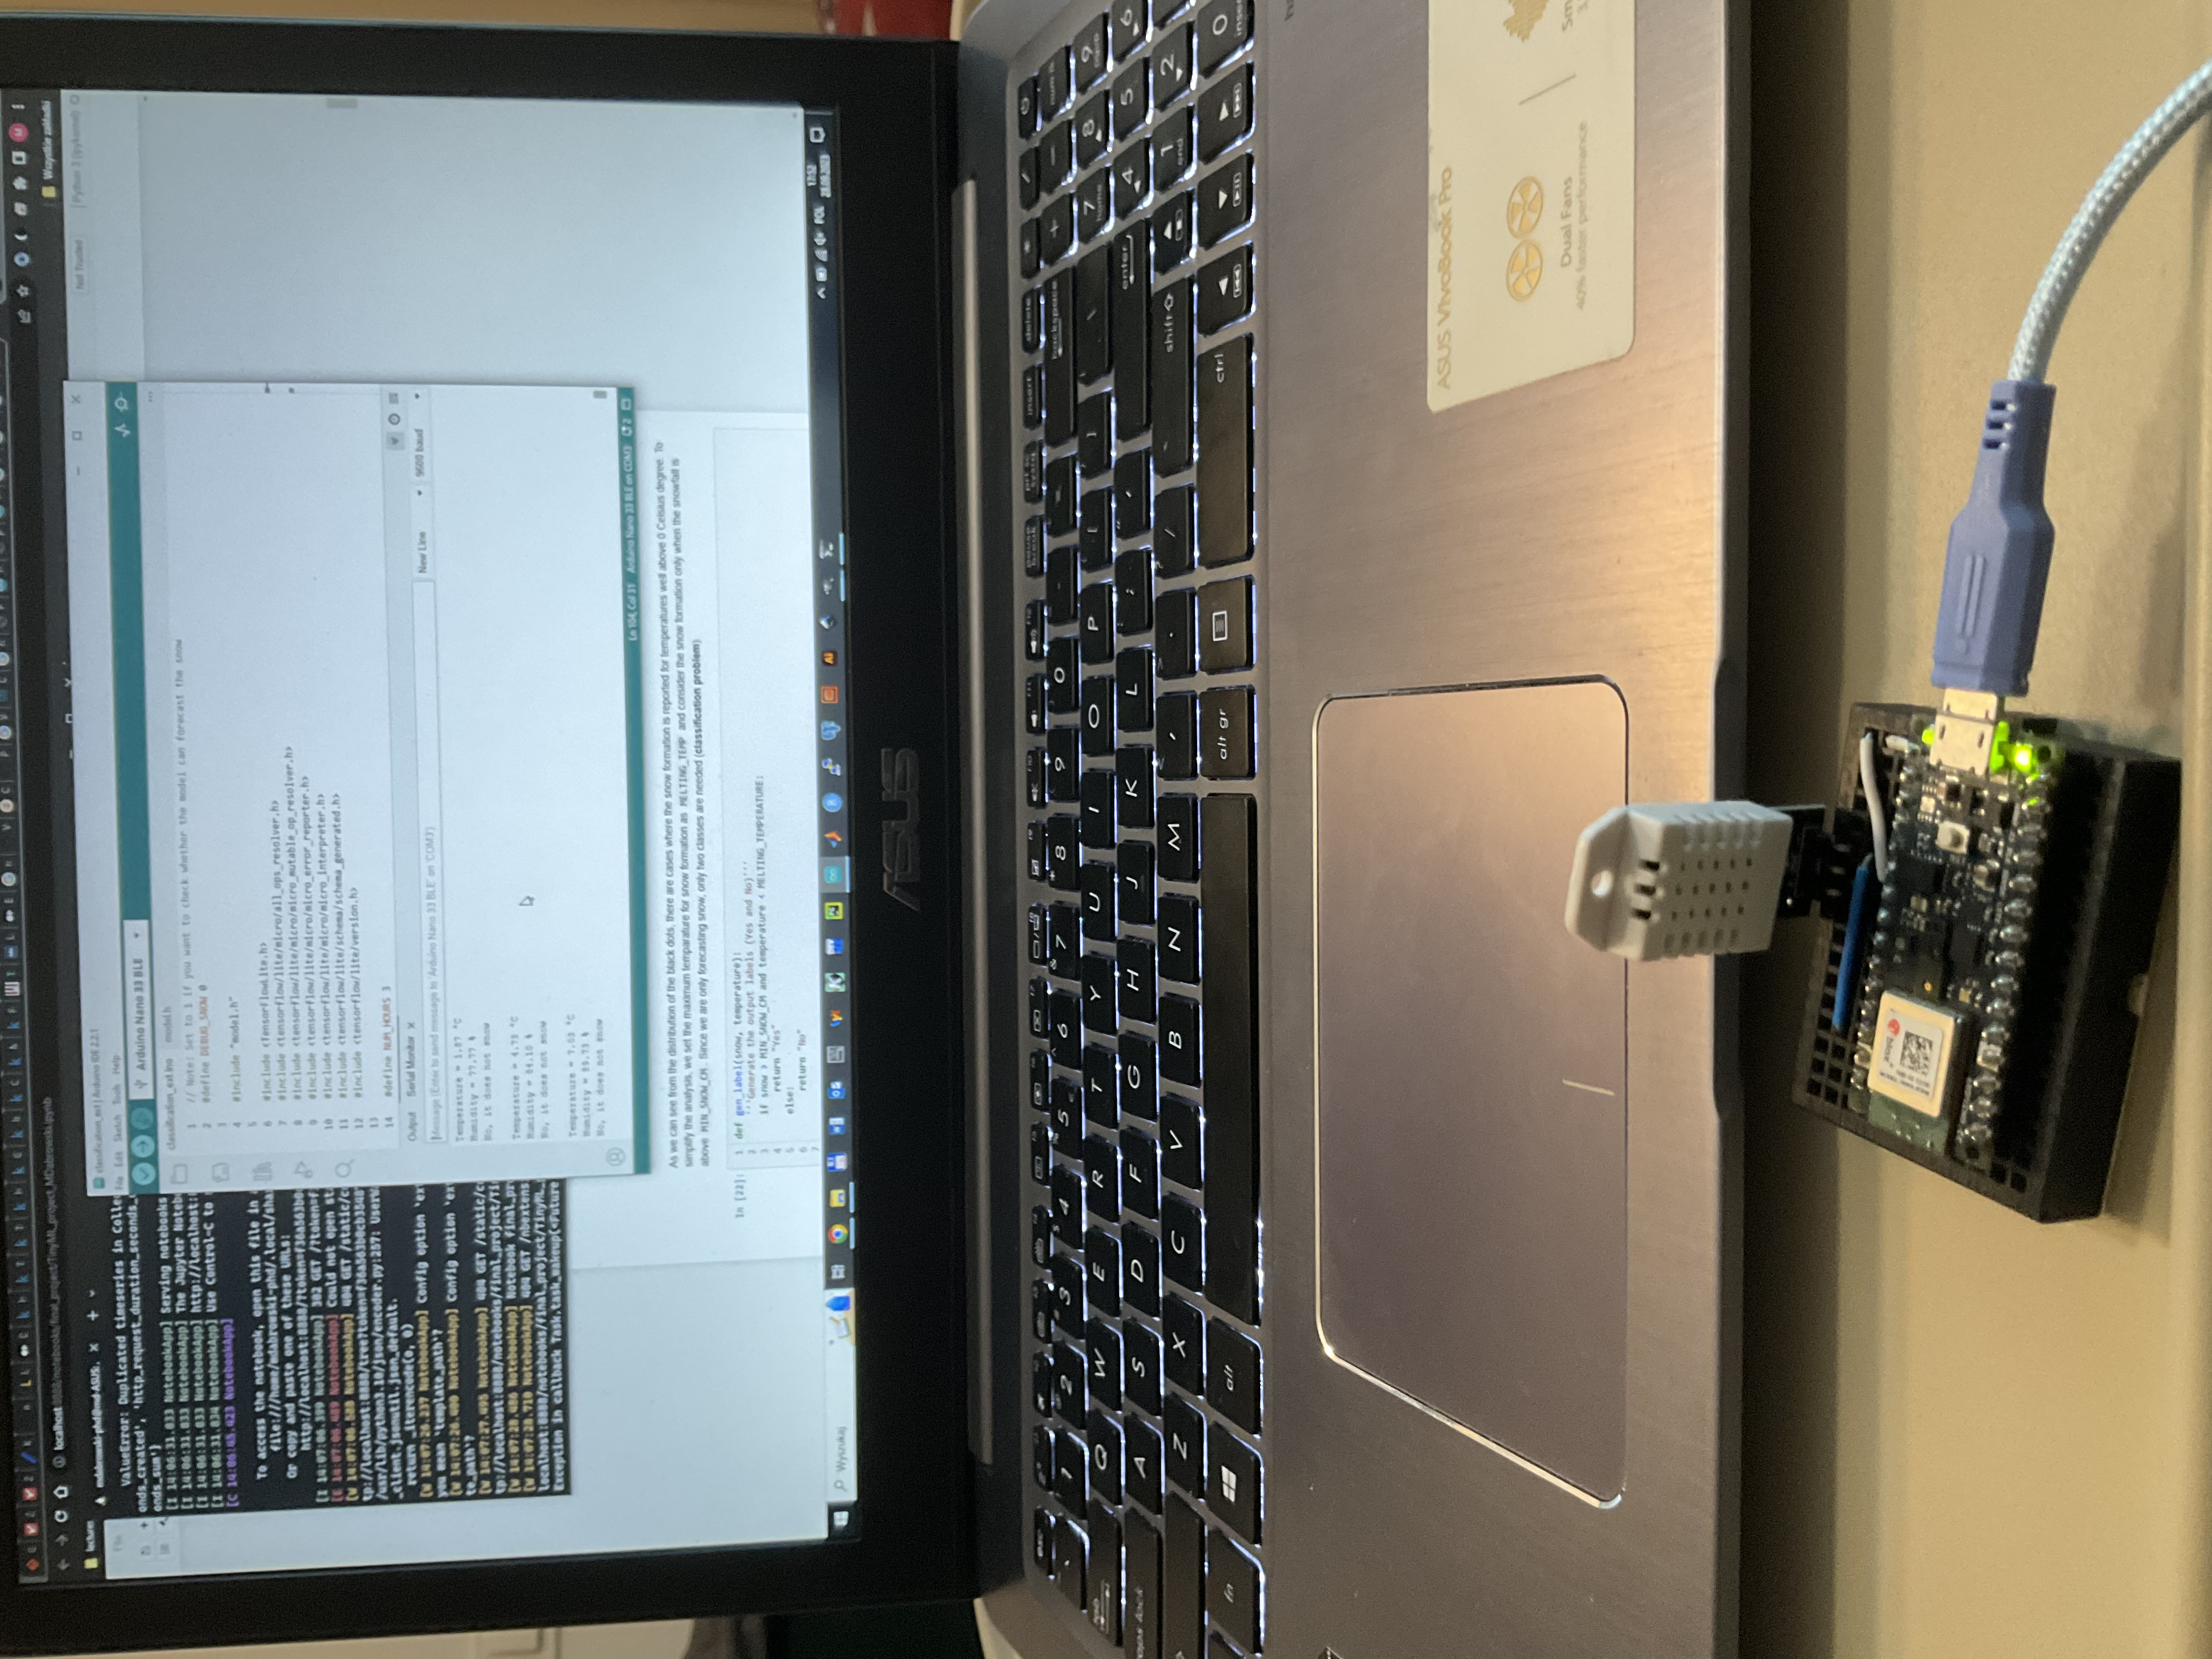
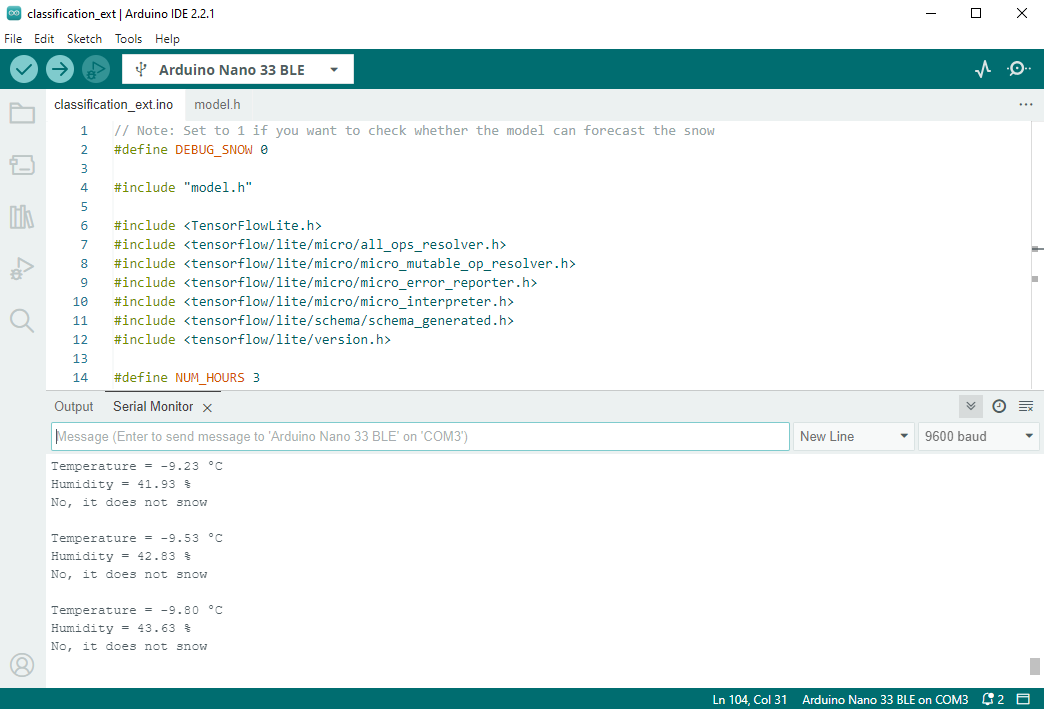

## Conclusion and Perspectives

__TO BE COMPLETED:__ what can be improved, comparison with similar models, different data sources, etc.